## NLP Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from dateutil.parser import *
import time
from dateutil import tz
import datetime as dt
import numpy as np
from numpy import argmax

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, roc_auc_score, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                             GradientBoostingClassifier, AdaBoostClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE 

import warnings 

warnings.filterwarnings('ignore')


In [40]:
data_library = {
    'XAU_USD' :  { "pair" :  'XAU_USD', "units": 3,    "pip": 0.1},
    }

In [41]:
#getting the pkl file name of certain pair
def get_his_data_filename(pair, granularity,time_from = None, time_to = None):
    
    if time_from:
        
        return f"./datasets/{pair}_{granularity}_{time_from}_{time_to}.pkl"
        
    else:
        return f"./datasets/{pair}_{granularity}.pkl"

# change timezone from string to timestamp
def parser(row):
    d= parse(row)
    return d


In [37]:
# load in our minute candles

xau_usd_M1_2015_042822 = pd.read_pickle('./datasets/xau_usd_M1_2015_042822_sg.pkl')

In [38]:
# putting candles dataframe into our event_df dataframes again for each event
event_df = pd.read_pickle('./datasets/ff_event_df_010115_033122.pkl')
event_df = event_df.loc[event_df['event_date_time'].drop_duplicates(keep='first').index]

event_df['candles']= 0

event_df['candles'] = event_df['candles'].astype('object')

drop_event = []
for i in event_df.index:
    try:
        index = xau_usd_M1_2015_042822[xau_usd_M1_2015_042822['time'] == event_df.loc[i]['event_date_time']].index[0]-1
        event_df['candles'][i] = xau_usd_M1_2015_042822.loc[index:(index+28800)]
    except:
        drop_event.append(i)
        
event_df = event_df.drop(drop_event,axis=0)
event_df.reset_index(inplace=True,drop=True)

event_df

,day_of_week,event_date_time,event_time_holder,curr,impact,event,previous,forecast,actual,candles
0,Fri,2015-01-02 23:00:00+08:00,15:00,USD,high,ISM Manufacturing PMI,58.7,57.6,55.5,time volume mi...
1,Mon,2015-01-05 21:00:00+08:00,13:00,USD,medium,FOMC Member Williams Speaks,,,,time volume mi...
2,Tue,2015-01-06 23:00:00+08:00,15:00,USD,high,ISM Services PMI,59.3,58.2,56.2,time volume mi...
3,Wed,2015-01-07 21:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,227K,227K,241K,time volume mi...
4,Wed,2015-01-07 21:30:00+08:00,13:30,USD,high,Trade Balance,-42.2B,-42.3B,-39.0B,time volume mi...
...,...,...,...,...,...,...,...,...,...,...
3033,Tue,2022-03-29 22:00:00+08:00,15:00,USD,high,JOLTS Job Openings,11.28M,11.00M,11.27M,time volume ...
3034,Wed,2022-03-30 20:15:00+08:00,13:15,USD,high,ADP Non-Farm Employment Change,486K,455K,455K,time volume ...
3035,Wed,2022-03-30 20:30:00+08:00,13:30,USD,medium,Final GDP q/q,7.0%,7.0%,6.9%,time volume ...
3036,Wed,2022-03-30 22:30:00+08:00,15:30,USD,medium,Crude Oil Inventories,-2.5M,-2.0M,-3.4M,time volume ...


In [21]:
# As per previous notebook, we are running the baseline momemtum strategy again 
#\n to record the volatile trades, success and decision in our event_df as labels for our nlp
# This is because we want to train our nlp model with successful, highly volatile events as labels.

# momemtum

pair='XAU_USD'

long_suc_count = 0
long_loss_count = 0

short_suc_count = 0
short_loss_count = 0

pips_exceed = 20

pips_tp = 20

results_columns = ['event','event_date_time','buy_date','sell_date','initial_price','initial_buy_price','pre_entry_candle','entry_candle',
                        'PAIR','decision','suc_price','fail_price','pips_exceed','pips_tp']
 
results_df =pd.DataFrame(columns = results_columns)

event_df = event_df.dropna(subset = ['candles'])

event_df.reset_index(inplace=True,drop=True)

event_df['volatile'] = 0

event_df['suc'] = 0

event_df['decision'] = 0

for i in range(len(event_df)):
    
    candles_df = event_df['candles'][i]

    initial_price = candles_df['mid_c'].iloc[0]

    initial_long_price = initial_price + data_library[pair]['pip']*pips_exceed
    initial_short_price = initial_price - data_library[pair]['pip']*pips_exceed

    initial_long_tp = initial_long_price + data_library[pair]['pip']*pips_tp
    initial_long_sl = initial_long_price - data_library[pair]['pip']*pips_tp

    initial_short_tp = initial_short_price - data_library[pair]['pip']*pips_tp
    initial_short_sl = initial_short_price + data_library[pair]['pip']*pips_tp

    candles_df['bid_shift1'] = candles_df['bid_l'].shift(1)
    candles_df['ask_shift1'] = candles_df['ask_h'].shift(1)
    
    
    for j in range(5):
        try:
            if candles_df['bid_l'].iloc[j]<= initial_short_price:

                event_df.loc[i,'volatile'] = 1

                event_df.loc[i,'decision'] = -1

                event = event_df['event'][i]

                event_time = event_df['event_date_time'][i]

                buy_time = candles_df['time'].iloc[j]

                pre_entry_candle = candles_df['bid_shift1'].iloc[j]

                entry_candle = candles_df['bid_l'].iloc[j]
                
                decision = -1

                after_time_df = candles_df[j+1:].copy()

                after_time_df.reset_index(inplace=True,drop=True)

                for k in range(len(after_time_df)):

                    if after_time_df['ask_l'][k]<=initial_short_tp:
                        suc_price = after_time_df['ask_l'][k]
                        sell_time = after_time_df['time'][k]

                        short_suc_count +=1

                        event_df.loc[i,'suc'] = 1

                        results_df = results_df.append(pd.Series([event,event_time,buy_time,sell_time,initial_price,initial_short_price,
                                                                    pre_entry_candle,
                                                                    entry_candle,pair,decision,suc_price,np.nan,
                                                                    pips_exceed,pips_tp],
                                                                    index= results_columns),
                                                                    ignore_index=True)

                        break

                    if after_time_df['ask_h'][k]>=initial_short_sl:
                        fail_price = after_time_df['ask_h'][k]
                        sell_time = after_time_df['time'][k]

                        short_loss_count +=1
                        results_df = results_df.append(pd.Series([event,event_time,buy_time,sell_time,initial_price,initial_short_price,
                                                                    pre_entry_candle,
                                                                    entry_candle,pair,decision,np.nan,fail_price,
                                                                    pips_exceed,pips_tp],
                                                                    index= results_columns),
                                                                    ignore_index=True)

                        break

                break

            if candles_df['ask_h'].iloc[j]>= initial_long_price:
                    
                event_df.loc[i,'volatile'] = 1

                event_df.loc[i,'decision'] = 1

                event = event_df['event'][i]

                event_time = event_df['event_date_time'][i]

                buy_time = candles_df['time'].iloc[j]
                pre_entry_candle = candles_df['ask_shift1'].iloc[j]

                entry_candle = candles_df['ask_h'].iloc[j]
                
                decision = 1

                after_time_df = candles_df[j+1:].copy()

                after_time_df.reset_index(inplace=True,drop=True)

                for k in range(len(after_time_df)):

                    if after_time_df['bid_h'][k]>=initial_long_tp:

                        suc_price = after_time_df['bid_h'][k]
                        sell_time = after_time_df['time'][k]

                        long_suc_count +=1

                        event_df.loc[i,'suc'] = 1

                        results_df = results_df.append(pd.Series([event,event_time,buy_time,sell_time,initial_price,initial_long_price,
                                                                    pre_entry_candle, entry_candle,pair,decision,suc_price,np.nan,
                                                                    pips_exceed,pips_tp],
                                                                    index= results_columns),
                                                                    ignore_index=True)

                        break

                    if after_time_df['bid_l'][k]<=initial_long_sl:
                        fail_price = after_time_df['bid_l'][k]
                        sell_time = after_time_df['time'][k]

                        long_loss_count +=1

                        results_df = results_df.append(pd.Series([event,event_time,buy_time,sell_time,initial_price,initial_long_price,
                                                                    pre_entry_candle, entry_candle,pair,decision,np.nan,fail_price,
                                                                    pips_exceed,pips_tp],
                                                                    index= results_columns),
                                                                    ignore_index=True)

                        break
                    
                    
                break                   
        except:
            print(i)
    
display(f'long win percentage: {round(long_suc_count/(long_suc_count+long_loss_count),2)}')

display(f'short win percentage: {round(short_suc_count/(short_suc_count+short_loss_count),2)}')

display(f'total win percentage: {round((short_suc_count+long_suc_count)/(short_suc_count+short_loss_count+long_suc_count+long_loss_count),2)}')

results_df

'long win percentage: 0.39'

'short win percentage: 0.36'

'total win percentage: 0.37'

,event,event_date_time,buy_date,sell_date,initial_price,initial_buy_price,pre_entry_candle,entry_candle,PAIR,decision,suc_price,fail_price,pips_exceed,pips_tp
0,ISM Manufacturing PMI,2015-01-02 23:00:00+08:00,2015-01-02 23:00:00+08:00,2015-01-02 23:04:00+08:00,1171.736,1173.736,1172.572,1174.512,XAU_USD,1,NaN,1171.357,20,20
1,FOMC Member Williams Speaks,2015-01-05 21:00:00+08:00,2015-01-05 21:02:00+08:00,2015-01-05 21:04:00+08:00,1189.229,1187.229,1187.775,1186.696,XAU_USD,-1,NaN,1189.884,20,20
2,ISM Services PMI,2015-01-06 23:00:00+08:00,2015-01-06 23:01:00+08:00,2015-01-06 23:16:00+08:00,1210.108,1212.108,1211.666,1213.430,XAU_USD,1,NaN,1208.575,20,20
3,ADP Non-Farm Employment Change,2015-01-07 21:15:00+08:00,2015-01-07 21:15:00+08:00,2015-01-07 21:17:00+08:00,1212.779,1210.779,1212.300,1207.833,XAU_USD,-1,NaN,1213.357,20,20
4,Crude Oil Inventories,2015-01-07 23:30:00+08:00,2015-01-07 23:33:00+08:00,2015-01-07 23:42:00+08:00,1211.672,1213.672,1213.428,1213.737,XAU_USD,1,1215.848,NaN,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1250,FOMC Member Waller Speaks,2022-03-24 22:10:00+08:00,2022-03-24 22:12:00+08:00,2022-03-24 22:18:00+08:00,1952.555,1954.555,1954.326,1954.770,XAU_USD,1,1959.792,NaN,20,20
1251,Flash Manufacturing PMI,2022-03-24 22:45:00+08:00,2022-03-24 22:46:00+08:00,2022-03-24 22:57:00+08:00,1963.650,1961.650,1961.833,1961.628,XAU_USD,-1,NaN,1964.518,20,20
1252,Revised UoM Consumer Sentiment,2022-03-25 23:00:00+08:00,2022-03-25 23:03:00+08:00,2022-03-25 23:22:00+08:00,1952.910,1954.910,1953.727,1955.168,XAU_USD,1,1958.712,NaN,20,20
1253,JOLTS Job Openings,2022-03-29 22:00:00+08:00,2022-03-29 22:00:00+08:00,2022-03-29 22:01:00+08:00,1907.530,1905.530,1906.634,1905.441,XAU_USD,-1,NaN,1913.078,20,20


Now, we will try a nlp based strategy where we try to identify words that may cause volatility. Through count vectorizer, we will use a bag of words model and classify whether each event is successfully volatile, whereby not only will it cross the 20 pips trigger point, it will also hit the 40 pips take profit point.

In [22]:
# identifying stop words

stop_words = CountVectorizer(stop_words = 'english').get_stop_words()

new_stop_words =[]

for word in stop_words:
    new_stop_words.append(word)

    
# From our eda, we identified some general words that we will stop out apart form the standard english words
new_stop_words.extend(['m/m','q/q','y/y'])

In [23]:
# create a dictionary for words: lemmatized words

lemma_dict ={}

# tokenizer for vectorizer

class StringTokenizer(object):

    def __init__(self):
        self.lem = WordNetLemmatizer()
    
    def __call__(self,object):
        
        for w in word_tokenize(object):
            
            lemma_dict[w] = self.lem.lemmatize(w) #update dict
            
        lemma_list= [self.lem.lemmatize(w) for w in word_tokenize(object)]  
        
        tokenized_list= [w for w in word_tokenize(object)]  
        
        return lemma_list

In [24]:
cvec= CountVectorizer(stop_words = new_stop_words,
                      tokenizer=StringTokenizer(), max_features =1000, ngram_range = (1,1))

cvec


CountVectorizer(max_features=1000,
                stop_words=['until', 'less', 'many', 'never', 'all', 'moreover',
                            'here', 'ours', 'thin', 'us', 'always', 'else',
                            'cannot', 'put', 'after', 'above', 'herein', 'top',
                            'each', 'other', 'during', 'any', 'who', 'inc',
                            'if', 'have', 'it', 'would', 'three', 'within', ...],
                tokenizer=<__main__.StringTokenizer object at 0x7fab3ae1e510>)

In [25]:
eda_all_cvec = pd.DataFrame(cvec.fit_transform(event_df['event']).todense(),columns= cvec.get_feature_names())
eda_volatile_cvec = pd.DataFrame(cvec.fit_transform(event_df[event_df['suc']==1]['event']).todense(),columns = cvec.get_feature_names())

Text(0.5, 1.0, 'Top 15 words for events')

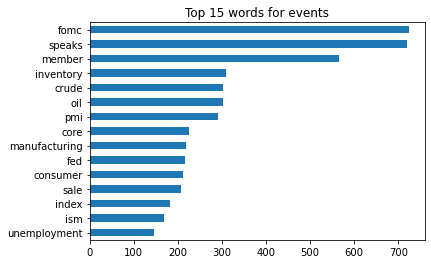

In [26]:
# top 15 most used words
eda_all_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 words for events')

Text(0.5, 1.0, 'Frequently occuring words for events')

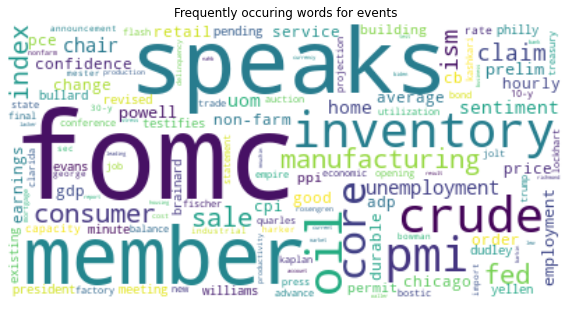

In [27]:
#wordcloud

eda_all_dict = dict(zip(eda_all_cvec.sum().index,eda_all_cvec.sum()))

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(eda_all_dict)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently occuring words for events')

Text(0.5, 1.0, 'Top 15 words for volatile events')

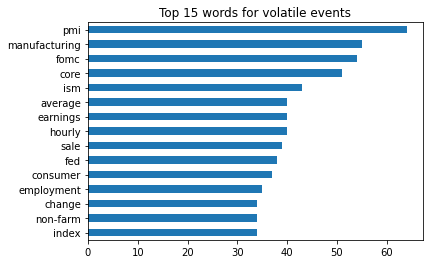

In [30]:
#### top 15 most used words
eda_volatile_cvec.sum().sort_values(ascending=True).tail(15).plot(kind='barh')
plt.title('Top 15 words for volatile events')

Text(0.5, 1.0, 'Frequently occuring words for volatile events')

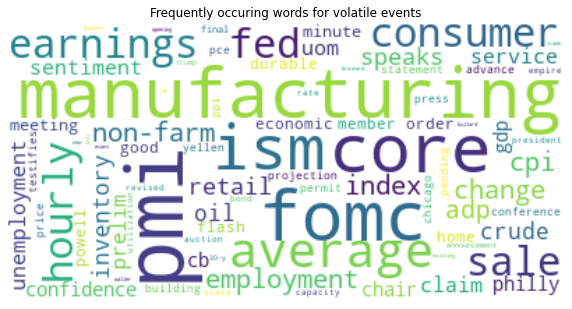

In [31]:
#wordcloud for only volatile events

eda_volatile_dict = dict(zip(eda_volatile_cvec.sum().index, eda_volatile_cvec.sum()))

plt.figure(figsize=(10,6))
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(eda_volatile_dict)
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.title('Frequently occuring words for volatile events')


We see that things like pmi (index of the prevailing direction of economic trends in the manufacturing and service sectors), earnings and non-farm (non-farm payroll) are words that result in volatility. We notice that fomc (Federal Open Market Committee) is a word that is used often, and it usually comes with the word 'FOMC member speaks'. However, speaks is not in the top words for volatility. We should hence remove stop it so that our model does not mistakenly think that 'speaks' and 'member' is a crucial word, whereas FOMC is actually the word that results in volatility.


In [83]:
new_stop_words.extend(['speaks','member'])


In [84]:
x = event_df['event']
y = event_df['suc'] #successful volatile events

x_train,x_test,y_train,y_test = train_test_split(x,y, random_state = 0, stratify = y, test_size = 0.1)

In [85]:
y_test.value_counts(normalize =True)

# only 15% of the events are successful volatile events. It would be advisable 
#\n to smote the data to create artificial training points for our model to detect volatile events better


0    0.845395
1    0.154605
Name: suc, dtype: float64

In [86]:
cvec= CountVectorizer(stop_words = new_stop_words,
                      tokenizer=StringTokenizer(), max_features =1000, ngram_range = (1,1))

cvec


CountVectorizer(max_features=1000,
                stop_words=['this', 'at', 'third', 'de', 'is', 'several',
                            'among', 'seem', 'in', 'they', 'another', 'twenty',
                            'along', 'almost', 'fifty', 'been', 'my', 'perhaps',
                            'further', 'do', 'even', 'move', 'thence', 'anyway',
                            'whereupon', 'whither', 'alone', 'off', 'many',
                            'an', ...],
                tokenizer=<__main__.StringTokenizer object at 0x7fbd7fae0190>)

In [87]:
x_train_cvec = pd.DataFrame(cvec.fit_transform(x_train).todense(),columns= cvec.get_feature_names())
x_test_cvec = pd.DataFrame(cvec.transform(x_test).todense(),columns = cvec.get_feature_names())


In [88]:
x_train_cvec

,10-y,30-y,account,adp,advance,announcement,auction,average,balance,bank,...,trade,treasury,trump,unemployment,unit,uom,utilization,waller,williams,yellen
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [89]:
# smoting the data to resolve imbalance
sm = SMOTE(random_state=0)
x_train_cvec, y_train = sm.fit_resample(x_train_cvec,y_train)


In [216]:
models = {'lr':LogisticRegression(random_state = 0), 
          'et':ExtraTreesClassifier(random_state = 0), 
          'SVM':SVC(probability=True,random_state = 0), 
          'rf':RandomForestClassifier(random_state = 0), 
          'ada': AdaBoostClassifier(random_state = 0),
          'gb' :GradientBoostingClassifier(random_state = 0), 
          'xgb': XGBClassifier(random_state = 0), 
          'nb' :MultinomialNB()
          }



In [226]:
model_list = []

def run_model(model_name):
    
    results = {}

    model = models[model_name]

    model.fit(x_train_cvec,y_train)

    predictions = model.predict(x_test_cvec)

    pred_probs = model.predict_proba(x_test_cvec)[:,1]

    cm = confusion_matrix(y_test,predictions)

    tn, fp, fn, tp = cm.ravel()
    
    results['model_name'] = model_name
    
    results['train_score'] = model.score(x_train_cvec, y_train)
    
    results['test_score'] = model.score(x_test_cvec, y_test)
    
    # precision will have some importance for us. This means that we want to max the identified winning trades, 
    #\n while minimizing identifying trades that are not volatile/not profitable so we do not take the trades
    
    results['precision'] = precision_score(y_test, 
                                           predictions)
    
    # we want to record true positives as we want to know how many winning trades it correctly identified
    
    results['true positive'] = tp
    
    # making a list of thresholds to optimize profit
    
    thresholds = np.linspace(0,1,21)
    
    total_win = []
    total_loss = []
    
    for threshold in thresholds:
    
        pred_df = pd.DataFrame({'true_values':y_test, 'pred_probs':pred_probs})
        pred_df['new_pred'] = np.where(pred_df['pred_probs']>threshold,1,0)
        
        # remember that our trade is only activated when it has passed the volatility threshold of 20 pips.
        # hence, even when we identified the trade is a possible winning trade, we will filter out the ones that
        #\n are volatile as they are the ones where our stop limits are triggered, and the rest will just expire
        # after identifying the trades that are volatile, we then can calculate whether the triggered trade 
        #\n is a win or loss and hence profitability. We will then find the threshold that max profitability
        
        total_winning_trades = event_df.loc[pred_df[pred_df['new_pred']==1].index]['suc'].sum()
        
        predict_df = event_df.loc[pred_df[(pred_df['new_pred']==1)].index]

        total_triggered_trades = len(predict_df[predict_df['volatile']==1])

        total_losing_trades = total_triggered_trades - total_winning_trades 
        
        total_win.append(total_winning_trades)
        
        total_loss.append(total_losing_trades)
    
    # finding best threshold
    
    diff = np.array(total_win) - np.array(total_loss)
    max_index = argmax(diff)
    best_thresh = thresholds[max_index]
    
    # rerunning to record the best threshold and profit
    
    pred_df = pd.DataFrame({'true_values':y_test, 'pred_probs':pred_probs})

    pred_df['new_pred'] = np.where(pred_df['pred_probs']> best_thresh,1,0)

    total_winning_trades = event_df.loc[pred_df[pred_df['new_pred']==1].index]['suc'].sum()

    predict_df = event_df.loc[pred_df[(pred_df['new_pred']==1)].index]

    total_triggered_trades = len(predict_df[predict_df['volatile']==1])

    total_losing_trades = total_triggered_trades - total_winning_trades 
    
    results['best_threshold'] = best_thresh
    
    results['total_profit'] = total_winning_trades - total_losing_trades
    
    model_list.append(results)
    
    print(model_name)
    print(f'Acc: {model.score(x_test_cvec,y_test)}')
    print(f'True Negatives: {tn}')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}')
    print(f'False Negatives: {fn}')
    print()
    

In [227]:
for model in models:
    run_model(model)

lr
Acc: 0.5986842105263158
True Negatives: 151
True Positives: 31
False Positives: 106
False Negatives: 16

et
Acc: 0.5953947368421053
True Negatives: 150
True Positives: 31
False Positives: 107
False Negatives: 16

SVM
Acc: 0.5953947368421053
True Negatives: 150
True Positives: 31
False Positives: 107
False Negatives: 16

rf
Acc: 0.5953947368421053
True Negatives: 150
True Positives: 31
False Positives: 107
False Negatives: 16

ada
Acc: 0.5328947368421053
True Negatives: 127
True Positives: 35
False Positives: 130
False Negatives: 12

gb
Acc: 0.5592105263157895
True Negatives: 138
True Positives: 32
False Positives: 119
False Negatives: 15

[00:15:47] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old

In [228]:
pd.DataFrame(model_list)

,model_name,train_score,test_score,precision,true positive,best_threshold,total_profit
0,lr,0.722126,0.598684,0.226277,31,0.85,0
1,et,0.730121,0.595395,0.224638,31,0.90,0
2,SVM,0.729689,0.595395,0.224638,31,0.70,0
3,rf,0.730121,0.595395,0.224638,31,0.90,0
4,ada,0.703976,0.532895,0.212121,35,0.55,0
5,gb,0.709810,0.559211,0.211921,32,0.75,0
6,xgb,0.719965,0.592105,0.223022,31,0.90,0
7,nb,0.694468,0.601974,0.223881,30,0.90,0


After we identified that this could be a winning trade (positive), we also have to calculate our true profit from all the positive trades identified. Even after searching through the different thresholds to find a a profitable threshold, the model is telling us that non of the thresholds for each model is profitable, and we should just not trade. Hence, we can see that nlp is not very useful in helping us identify profitable winning trades.
